               Age           GP            G            A          PTS  \
count  2522.000000  2522.000000  2522.000000  2522.000000  2522.000000   
mean     26.492466    49.057891     8.837431    14.820777    23.658208   
std       3.940371    18.667507     8.524537    12.302175    19.300001   
min      18.000000    10.000000     0.000000     0.000000     0.000000   
25%      23.000000    38.000000     3.000000     6.000000     9.000000   
50%      26.000000    48.000000     6.000000    12.000000    19.000000   
75%      29.000000    65.000000    13.000000    21.000000    33.000000   
max      39.000000    82.000000    60.000000    85.000000   123.000000   

               +/-          PIM           PS          EVG          PPG  ...  \
count  2522.000000  2522.000000  2522.000000  2522.000000  2522.000000  ...   
mean      0.087629    23.424663     2.703727     6.781523     1.817209  ...   
std      11.424617    18.798881     2.491541     6.120262     2.963666  ...   
min     -46.00000

<AxesSubplot: xlabel='PR/GP', ylabel='Age'>

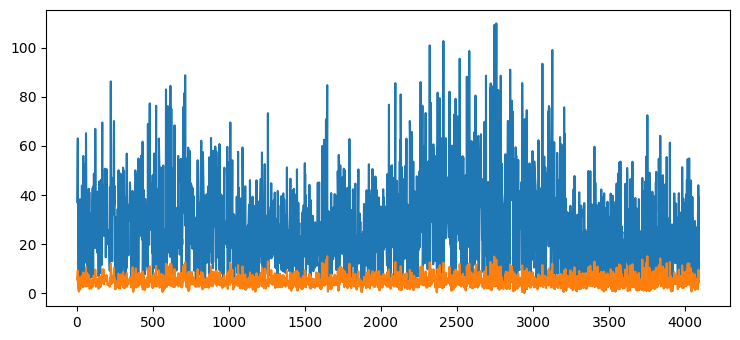

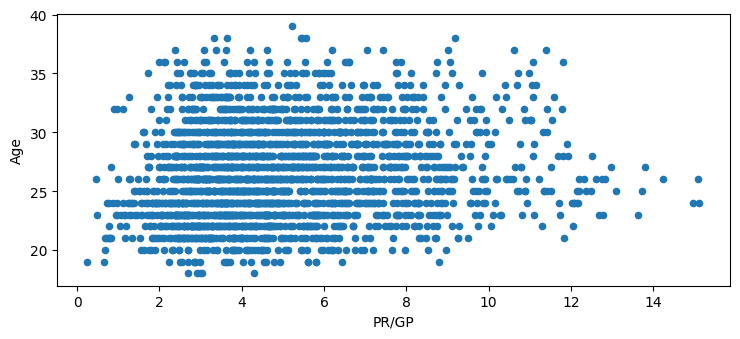

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import os
from bs4 import BeautifulSoup

# WEBSCRAPING STEP
all_data = ""
for page in range(2019, 2023):
    season = int(page + 1)
    url = "https://www.hockey-reference.com/leagues/NHL_{page}_skaters.html".format(page =page+1)

    #print(url)

    page = requests.get(url)

    soup = BeautifulSoup(page.content, "html.parser")
    
    for records in soup.select('tr[class != "colhead"]'):
        player_data = ""
        for data in records.findAll('td'):
            player_data = player_data + "," + data.text
        all_data = all_data + '\n' + player_data[1:]
    all_data = all_data + '\n' + "SEASON: " + str(season - 1) + "-" + str(season)
stat_headers = "Player,Age,Team,Pos,GP,G,A,PTS,+/-,PIM,PS,EVG,PPG,SHG,GW,EVA,PPA,SHA,S,S%,TOI,ATOI,BLK,HIT,FOW,FOL,FO%"
file = open(os.path.expanduser('nhl_player_stat_databasetest.csv'), 'wb')
all_data = stat_headers + '\n' + all_data
file.write(bytes(all_data, encoding='ascii', errors='ignore'))


# PANDAS & NUMPY TO FILTER/MODIFY DATA
df = pd.read_csv('nhl_player_stat_databasetest.csv')
columns = stat_headers

all_players_teams = df[['Player','Team']]   # all data in players & teams cols
all_tot = (df[df['Team'] == 'TOT'])   # all data for TOT players
subset_tot = all_tot[['Player','Team']]   # player & team name data for TOT players

# creating list containing names of TOT players:
tot_players = []
for num in (subset_tot).index.values:
  player_name = subset_tot._get_value(num,'Player')
  tot_players.append(player_name)

# remove next appearances of TOT player in list:
to_remove = []
for player in tot_players:
  lst = list(np.where(df['Player'] == player)[0])
  for num in lst:
    num += 1
    next_name = all_players_teams._get_value(num,'Player')
    if 'SEASON' in next_name:
      break
    elif next_name == player:
      (to_remove).append(num)

players_names = (df['Player']).values.tolist()  # list of players names

seasons = []
for entry in players_names:
  if 'SEASON' in entry:
    seasons.append(df[df['Player'] == entry].index.values)
# identify where last season begins
val = len(seasons) - 2
index_last_season = (seasons.pop(val))[0]

# check players from all but last season
past_players = []
for num in range(index_last_season):
  past_players.append(all_players_teams._get_value(num,'Player'))

# create list of names of players in current season
curr_players = []
for num in range(index_last_season+1,seasons.pop()[0]):
  curr_players.append(all_players_teams._get_value(num,'Player'))

for player in past_players:
  if player not in curr_players:
    #print(f'player: {player}')
    # remove all instances of player by appending index to to_remove
    indices_to_remove = list(np.where(df['Player'] == player)[0])
    # print(f'indices_to_remove: {indices_to_remove}')

  for num in indices_to_remove:
    to_remove.append(num)

# remove data for TOT players + inactive players in to_remove
df.drop(to_remove, axis=0, inplace=True)

# check for num of games played
df.replace(np.nan,0)
df = df[df['GP'] > 9]
df['PLAYER_RATING'] = df["EVG"] * 0.8 + df["PPG"] * 0.65 + df["SHG"] * 0.8 + df["GW"] * 0.1 + df["EVA"] * 0.55 + df["PPA"] * 0.45 + df["SHA"] * 0.55 + df["S"] * 0.075 + df["BLK"] * 0.05 + df["PIM"] * 0.05 + df["FOW"] * 0.025 - df["FOL"] * 0.025 + df["HIT"] * 0.025 + df["+/-"] * 0.15
df['PR/GP'] = df["PLAYER_RATING"] / df["GP"] * 10

# pr_only_df = asdasdasd (this dataframe only has player rating and player rating per games played)
pd.set_option('display.max_rows', None)
# print(df.to_string)
# df.describe()
df.describe()

df.sort_values(["Player", "Age"], ascending=[True, True])
print(df.describe())
# df.sort_values(by="PLAYER_RATING", ascending=False)
# df.sort_values(by="PR/GP", ascending=False)
# df.groupby("PR/GP")["Player"]
df['PLAYER_RATING'].plot()
df['PR/GP'].plot()
df.plot.scatter(x="PR/GP", y="Age")
# NEXT TO-DO:
# - organize by player
# - create new variable, weighted_PR/GP
# - if player shows once, weighted_PR/GP = 1.0 * PR/GP
# - if a player shows twice, weighted_PR/GP = 0.35 * 1st_PR/GP + 0.65 * 2nd_PR/GP
# - if a player shows three times, weighted_PR/GP = 0.15 * 1st_PR/GP + 0.35 * 2nd_PR/GP + 0.5 * 3rd_PR/GP
#
# - after the above is completed, we can move onto visualizing the weighted_PR/GP
# OVERALL PLAYER RATING = weighted_PR/GP